## **DS5110 Final Project - HVAC**
### The goal of this project is to find out which Terminal Units (TUs) are connected to which Rooftop Units (RTUs) in a building, using data science techniques.

### **Author:** Bini Chandra

* **Load TU and RTU Files**

In [11]:
import os
import pandas as pd
import numpy as np
from functools import reduce
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Folder setup
tu_path = "./data_Bini/terminalUnits/"          # TU files folder
rtu_path = "./data_Bini/roofTopUnits/"          # RTU files folder

# Clean and save
cleaned_tu_data = {}
os.makedirs("./data_Bini/cleaned_data/cleaned_TUs", exist_ok=True)
cleaned_rtu_data = {}
os.makedirs("./data_Bini/cleaned_data/cleaned_RTUs", exist_ok=True)

#Load all 3 RTU files
print("Loaded RTU Files:")
rtu_data = {}
for file in sorted(os.listdir(rtu_path)):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(rtu_path, file))
        rtu_data[file] = df
        print(f"{file:<15} → {df.shape}")

#Load all 47 TU files
print("\nLoaded TU Files:")
tu_data = {}
for file in sorted(os.listdir(tu_path)):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(tu_path, file))
        tu_data[file] = df
        print(f"{file:<15} → {df.shape}")

Loaded RTU Files:
RTU_1.csv       → (4871, 35)
RTU_2.csv       → (4873, 35)
RTU_3.csv       → (4873, 22)

Loaded TU Files:
A.csv           → (4818, 23)
AA.csv          → (4816, 26)
B.csv           → (4818, 24)
BB.csv          → (4816, 27)
C.csv           → (4818, 24)
CC.csv          → (4816, 27)
D.csv           → (4818, 24)
DD.csv          → (4816, 26)
E.csv           → (4818, 24)
EE.csv          → (4816, 25)
F.csv           → (4818, 25)
FF.csv          → (4816, 26)
G.csv           → (4818, 25)
GG.csv          → (4816, 26)
H.csv           → (4818, 25)
HH.csv          → (4816, 26)
I.csv           → (4818, 26)
II.csv          → (4816, 26)
J.csv           → (4818, 26)
JJ.csv          → (4816, 26)
K.csv           → (4818, 26)
KK.csv          → (4816, 23)
L.csv           → (4818, 26)
LL.csv          → (4816, 23)
M.csv           → (4818, 26)
MM.csv          → (4816, 23)
N.csv           → (4818, 26)
NN.csv          → (4816, 23)
O.csv           → (4818, 26)
OO.csv          → (4816, 23)
P.csv  


**Observations:**

3 RTU files: RTU_1 and RTU_2 have 35 columns. RTU_3 has only 22 columns (less informative → probably the unconnected one).

* **Drop client-specified columns and forward-fill the setpoints**
    

    As per client, we can drop Air_Flow_Diff, Room_Temperature_Diff, VAV_Temperature_Diff, oppMode, SaTemp, SaTmp, SuplFanCmd.

In [12]:

# Columns to drop (as per client's suggestion)
columns_to_drop = [
    'Air_Flow_Diff', 'Room_Temperature_Diff',
    'VAV_Temperature_Diff', 'SaTemp', 'SaTmp', 'oppMode']

# Function to forward-fill only setpoint-related columns
def forward_fill_setpoints(df):
    for col in df.columns:
        if "Sp" in col:
            df[col] = df[col].ffill()
    return df

# Reusable cleaning function
def clean_dataframe_dict(data_dict):
    cleaned_data = {}
    for filename, df in data_dict.items():
        df_cleaned = df.copy()
        df_cleaned = forward_fill_setpoints(df_cleaned)
        df_cleaned.drop(columns=[col for col in columns_to_drop if col in df_cleaned.columns], inplace=True)
        cleaned_data[filename] = df_cleaned
        print(f"Cleaned {filename:<15} → {df_cleaned.shape}")
    return cleaned_data

# Apply cleaning
cleaned_tu_data = clean_dataframe_dict(tu_data)
cleaned_rtu_data = clean_dataframe_dict(rtu_data)


Cleaned A.csv           → (4818, 18)
Cleaned AA.csv          → (4816, 21)
Cleaned B.csv           → (4818, 19)
Cleaned BB.csv          → (4816, 22)
Cleaned C.csv           → (4818, 19)
Cleaned CC.csv          → (4816, 22)
Cleaned D.csv           → (4818, 19)
Cleaned DD.csv          → (4816, 21)
Cleaned E.csv           → (4818, 19)
Cleaned EE.csv          → (4816, 20)
Cleaned F.csv           → (4818, 20)
Cleaned FF.csv          → (4816, 21)
Cleaned G.csv           → (4818, 20)
Cleaned GG.csv          → (4816, 21)
Cleaned H.csv           → (4818, 20)
Cleaned HH.csv          → (4816, 21)
Cleaned I.csv           → (4818, 21)
Cleaned II.csv          → (4816, 21)
Cleaned J.csv           → (4818, 21)
Cleaned JJ.csv          → (4816, 21)
Cleaned K.csv           → (4818, 21)
Cleaned KK.csv          → (4816, 18)
Cleaned L.csv           → (4818, 21)
Cleaned LL.csv          → (4816, 18)
Cleaned M.csv           → (4818, 21)
Cleaned MM.csv          → (4816, 18)
Cleaned N.csv           → (4818, 21)
C

In [13]:
# Check how many TU files each column appears in
column_appearance = defaultdict(set)

for filename, df in cleaned_tu_data.items():
    for column in df.columns:
        column_appearance[column].add(filename)

print("Columns found across TU files:\n")
for col in sorted(column_appearance, key=lambda x: -len(column_appearance[x])):
    print(f"{col:<15} → {len(column_appearance[col])}/47 files")


# Count how many TU files have std = 0 for each column
zero_std_columns = defaultdict(set)

for filename, df in cleaned_tu_data.items():
    numeric_cols = df.select_dtypes(include='number')
    for col in numeric_cols.columns:
        if numeric_cols[col].std() == 0:
            zero_std_columns[col].add(filename)

print("\nColumns with std = 0 in some TU files:\n")
for col in sorted(zero_std_columns, key=lambda x: -len(zero_std_columns[x])):
    print(f"{col:<15} → {len(zero_std_columns[col])} files")


# Combine all TU data to check global std, min, max
merged_df = pd.concat(
    [df.assign(tu_name=name.replace(".csv", "")) for name, df in cleaned_tu_data.items()],
    ignore_index=True
)

global_stats = merged_df.describe().transpose()[['std', 'min', 'max']].sort_values(by='std')

print("\nGlobal STD, Min, Max for all numeric columns:\n")
print(global_stats.round(3))


Columns found across TU files:

time            → 47/47 files
AirFlow         → 47/47 files
ClgPct          → 47/47 files
DmprPos         → 47/47 files
DschAirTemp     → 47/47 files
EffAirflowSp    → 47/47 files
EffOcc          → 47/47 files
EffSp           → 47/47 files
HtgPct          → 47/47 files
OccClgSp        → 47/47 files
OccCmd          → 47/47 files
OccHtgSp        → 47/47 files
RmSp            → 47/47 files
RmTemp          → 47/47 files
StbyClgSp       → 47/47 files
StbyHtgSp       → 47/47 files
UnoccClgSp      → 47/47 files
UnoccHtgSp      → 47/47 files
RmCo2           → 27/47 files
Cooling_Stg_Cmd → 14/47 files
Heating_Stg_Cmd → 14/47 files
SuplFanCmd      → 9/47 files
SuplFanState    → 9/47 files
AirflowSpRht    → 3/47 files

Columns with std = 0 in some TU files:

EffOcc          → 47 files
OccClgSp        → 47 files
OccCmd          → 47 files
OccHtgSp        → 47 files
StbyClgSp       → 47 files
StbyHtgSp       → 47 files
UnoccClgSp      → 47 files
UnoccHtgSp      → 47 


**OBSERVATIONS: Columns to Drop:**

* EffOcc - Always 0

* OccCmd - Always 0

* SuplFanCmd - Only in 9 files and always constant

* SuplFanState - Only in 9 files and always constant

* Heating_Stg_Cmd - Only in 14 files and always constant

* Cooling_Stg_Cmd - Only in 14 files with minimal variation

* AirflowSpRht - Only in 3 files

* RmCo2 - Missing in many files (only in 27/47)

In [14]:
columns_to_drop = [
    'EffOcc','OccCmd','SuplFanCmd','SuplFanState','Heating_Stg_Cmd','Cooling_Stg_Cmd', 'AirflowSpRht', 'RmCo2'
]

for file, df in cleaned_tu_data.items():
    # Drop columns only if they exist in that file
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    print(f"Cleaned {file:<15} → {df.shape}")

Cleaned A.csv           → (4818, 16)
Cleaned AA.csv          → (4816, 16)
Cleaned B.csv           → (4818, 16)
Cleaned BB.csv          → (4816, 16)
Cleaned C.csv           → (4818, 16)
Cleaned CC.csv          → (4816, 16)
Cleaned D.csv           → (4818, 16)
Cleaned DD.csv          → (4816, 16)
Cleaned E.csv           → (4818, 16)
Cleaned EE.csv          → (4816, 16)
Cleaned F.csv           → (4818, 16)
Cleaned FF.csv          → (4816, 16)
Cleaned G.csv           → (4818, 16)
Cleaned GG.csv          → (4816, 16)
Cleaned H.csv           → (4818, 16)
Cleaned HH.csv          → (4816, 16)
Cleaned I.csv           → (4818, 16)
Cleaned II.csv          → (4816, 16)
Cleaned J.csv           → (4818, 16)
Cleaned JJ.csv          → (4816, 16)
Cleaned K.csv           → (4818, 16)
Cleaned KK.csv          → (4816, 16)
Cleaned L.csv           → (4818, 16)
Cleaned LL.csv          → (4816, 16)
Cleaned M.csv           → (4818, 16)
Cleaned MM.csv          → (4816, 16)
Cleaned N.csv           → (4818, 16)
C

* Check for Missing values

In [15]:
# Check how many rows in each file contain missing values
def check_missing_rows(data_dict, label="TU"):
    print(f"\n{'File':<15} | {'Missing rows':>15}")   
    for file, df in data_dict.items():
        missing = df.isnull().any(axis=1).sum()
        print(f"{file:<15} | {missing:>15}")

check_missing_rows(cleaned_tu_data, label="TU")
check_missing_rows(cleaned_rtu_data, label="RTU")


File            |    Missing rows
A.csv           |             248
AA.csv          |             247
B.csv           |             248
BB.csv          |            4492
C.csv           |             248
CC.csv          |             247
D.csv           |            4498
DD.csv          |             247
E.csv           |             248
EE.csv          |             247
F.csv           |             248
FF.csv          |             247
G.csv           |             248
GG.csv          |             247
H.csv           |             248
HH.csv          |             247
I.csv           |             248
II.csv          |             247
J.csv           |             248
JJ.csv          |             247
K.csv           |             248
KK.csv          |             247
L.csv           |             248
LL.csv          |             247
M.csv           |             248
MM.csv          |             247
N.csv           |             248
NN.csv          |             247
O.csv        

We will take a max threshold of 250 and delete rows with NaNs if ≤ 250 rows are affected.

Files BB.csv and D.csv have 4492 and 4498 rows with NaNs, so for now, we will exclude those files from deletion.

In [16]:
# Drop rows with NaNs only if ≤ 250 rows are affected
max_count = 250

def drop_missing(data_dict):    
    for file, df in data_dict.items():
        nan_rows = df.isnull().any(axis=1)
        nan_count = nan_rows.sum()
        
        if nan_count <= max_count:
            data_dict[file] = df[~nan_rows]

def save_to_csv(data_dict, folder_path):
    for file, df in data_dict.items():
        df.to_csv(os.path.join(folder_path, file), index=False)

drop_missing(cleaned_tu_data)
check_missing_rows(cleaned_tu_data, label="TU")
save_to_csv(cleaned_tu_data, "./data_Bini/cleaned_data/cleaned_TUs/")

drop_missing(cleaned_rtu_data)
check_missing_rows(cleaned_rtu_data, label="RTU")
save_to_csv(cleaned_rtu_data, "./data_Bini/cleaned_data/cleaned_RTUs/")



File            |    Missing rows
A.csv           |               0
AA.csv          |               0
B.csv           |               0
BB.csv          |            4492
C.csv           |               0
CC.csv          |               0
D.csv           |            4498
DD.csv          |               0
E.csv           |               0
EE.csv          |               0
F.csv           |               0
FF.csv          |               0
G.csv           |               0
GG.csv          |               0
H.csv           |               0
HH.csv          |               0
I.csv           |               0
II.csv          |               0
J.csv           |               0
JJ.csv          |               0
K.csv           |               0
KK.csv          |               0
L.csv           |               0
LL.csv          |               0
M.csv           |               0
MM.csv          |               0
N.csv           |               0
NN.csv          |               0
O.csv        

Now we will keep only the rows with timestamps that are present in all RTU and TU files.

In [17]:
# Output folders
synced_tu_folder = "./data_Bini/cleaned_data/cleaned_TUs_synced"
synced_rtu_folder = "./data_Bini/cleaned_data/cleaned_RTUs_synced"
os.makedirs(synced_tu_folder, exist_ok=True)
os.makedirs(synced_rtu_folder, exist_ok=True)

# Find common timestamps across all TU and RTU files
tu_times = [set(df['time']) for df in cleaned_tu_data.values() if 'time' in df.columns]
rtu_times = [set(df['time']) for df in cleaned_rtu_data.values() if 'time' in df.columns]
common_timestamps = sorted(reduce(lambda a, b: a & b, tu_times + rtu_times))
print(f"\nTotal Common Timestamps: {len(common_timestamps)}\n")

# Create dictionaries to store synchronized dataframes
synced_tu_data = {}
synced_rtu_data = {}

# Sync and save TU files
for file, df in cleaned_tu_data.items():
    if 'time' in df.columns:
        df_synced = df[df['time'].isin(common_timestamps)].sort_values(by='time').copy()
        df_synced['record_index'] = np.arange(1, len(common_timestamps) + 1)
        synced_tu_data[file] = df_synced
        df_synced.to_csv(os.path.join(synced_tu_folder, file), index=False)
        print(f"Synced TU: {file:<15} → {df_synced.shape}")

# Sync and save RTU files
for file, df in cleaned_rtu_data.items():
    if 'time' in df.columns:
        df_synced = df[df['time'].isin(common_timestamps)].sort_values(by='time').copy()
        df_synced['record_index'] = np.arange(1, len(common_timestamps) + 1)
        synced_rtu_data[file] = df_synced
        df_synced.to_csv(os.path.join(synced_rtu_folder, file), index=False)
        print(f"Synced RTU: {file:<15} → {df_synced.shape}")


Total Common Timestamps: 4568

Synced TU: A.csv           → (4568, 17)
Synced TU: AA.csv          → (4568, 17)
Synced TU: B.csv           → (4568, 17)
Synced TU: BB.csv          → (4568, 17)
Synced TU: C.csv           → (4568, 17)
Synced TU: CC.csv          → (4568, 17)
Synced TU: D.csv           → (4568, 17)
Synced TU: DD.csv          → (4568, 17)
Synced TU: E.csv           → (4568, 17)
Synced TU: EE.csv          → (4568, 17)
Synced TU: F.csv           → (4568, 17)
Synced TU: FF.csv          → (4568, 17)
Synced TU: G.csv           → (4568, 17)
Synced TU: GG.csv          → (4568, 17)
Synced TU: H.csv           → (4568, 17)
Synced TU: HH.csv          → (4568, 17)
Synced TU: I.csv           → (4568, 17)
Synced TU: II.csv          → (4568, 17)
Synced TU: J.csv           → (4568, 17)
Synced TU: JJ.csv          → (4568, 17)
Synced TU: K.csv           → (4568, 17)
Synced TU: KK.csv          → (4568, 17)
Synced TU: L.csv           → (4568, 17)
Synced TU: LL.csv          → (4568, 17)
Synced T

* Now we will identify which columns in TU and RTU data show strong correlations (|r| ≥ 0.85), then pick the most frequently correlated columns for further analysis.

TU columns : ['DschAirTemp', 'EffAirflowSp', 'RmTemp', 'DmprPos', 'AirFlow']
RTU columns : ['BldgStaticPresSp', 'SuplAirTemp', 'RmTemp', 'SuplAirStaticPres', 'OutAirTemp']


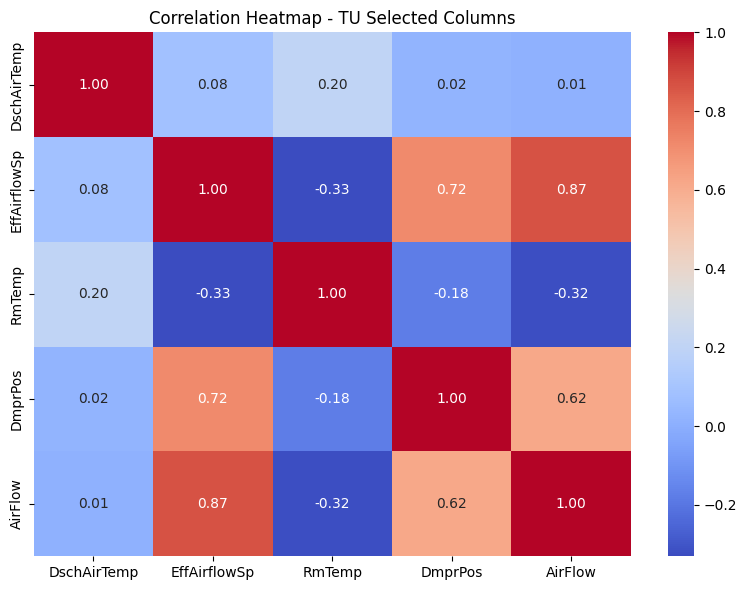

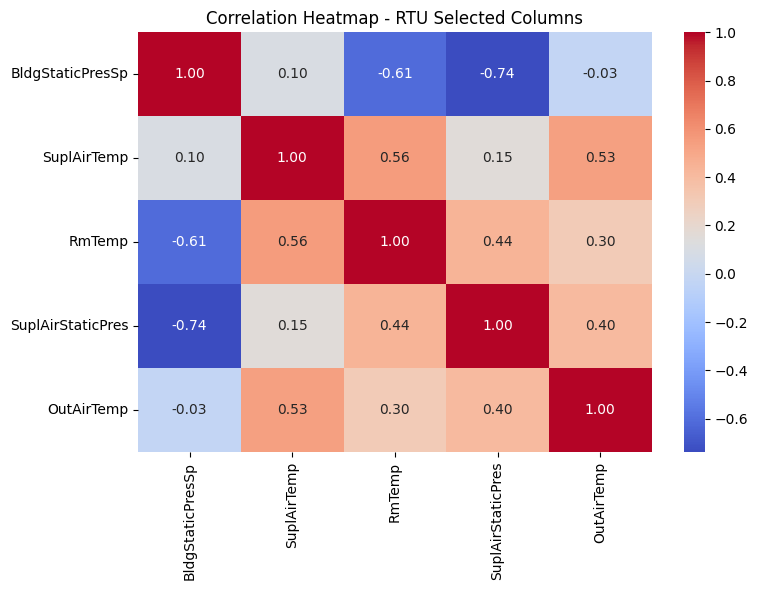

In [18]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from itertools import permutations
import matplotlib.pyplot as plt

# Load folders
tu_path = "./data_Bini/cleaned_data/cleaned_TUs_synced"
rtu_path = "./data_Bini/cleaned_data/cleaned_RTUs_synced"
excluded = {"BB.csv", "D.csv"}  # we don't want to use these TU files
correlation_threshold = 0.85    # only consider strong correlations
top_n_columns = 5               # pick top correlated columns

# Load TU and RTU files (only numeric columns and drop missing rows)
tu_data, rtu_data = {}, {}

for file in sorted(os.listdir(tu_path)):
    if file.endswith(".csv") and file not in excluded:
        name = file.replace(".csv", "")
        df = pd.read_csv(os.path.join(tu_path, file))
        df = df.drop(columns=['record_index'], errors='ignore')
        df = df.select_dtypes(include=np.number).dropna()
        tu_data[name] = df


for file in sorted(os.listdir(rtu_path)):
    if file.endswith(".csv") and "RTU_3" not in file:
        name = file.replace(".csv", "")
        df = pd.read_csv(os.path.join(rtu_path, file))
        df = df.drop(columns=['record_index'], errors='ignore')
        df = df.select_dtypes(include=np.number).dropna()
        rtu_data[name] = df


# Get TU and RTU columns that often show high correlation
strong_tu_columns = []
strong_rtu_columns = []

for tu_df in tu_data.values():
    for tu_col in tu_df.columns:
        if tu_df[tu_col].std() == 0:
            continue
        for rtu_df in rtu_data.values():
            for rtu_col in rtu_df.columns:
                if rtu_df[rtu_col].std() == 0:
                    continue
                corr = tu_df[tu_col].corr(rtu_df[rtu_col])
                if not np.isnan(corr) and abs(corr) >= correlation_threshold:
                    strong_tu_columns.append(tu_col)
                    strong_rtu_columns.append(rtu_col)

# Pick the n most common columns from the above list
tu_corr_cols = [col for col, _ in Counter(strong_tu_columns).most_common(top_n_columns)]
rtu_corr_cols = [col for col, _ in Counter(strong_rtu_columns).most_common(top_n_columns)]

# Remove the record_index from feature lists
tu_corr_cols = [c for c in tu_corr_cols if c != "record_index"]
rtu_corr_cols = [c for c in rtu_corr_cols if c != "record_index"]

print("TU columns :", tu_corr_cols)
print("RTU columns :", rtu_corr_cols)

import seaborn as sns

# Correlation Heatmap: TU Top Correlated Columns
tu_corr_matrix = pd.concat([df[tu_corr_cols] for df in tu_data.values()], axis=0).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(tu_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - TU Selected Columns")
plt.tight_layout()
plt.show()

# Correlation Heatmap: RTU Top Correlated Columns
rtu_corr_matrix = pd.concat([df[rtu_corr_cols] for df in rtu_data.values()], axis=0).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(rtu_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - RTU Selected Columns")
plt.tight_layout()
plt.show()

### KMeans Clustering on TU-RTU Merged Features
* Now we will merge each TU with every RTU using only the top correlated columns. This creates a large combined dataset where each row is a TU-RTU pair for clustering.

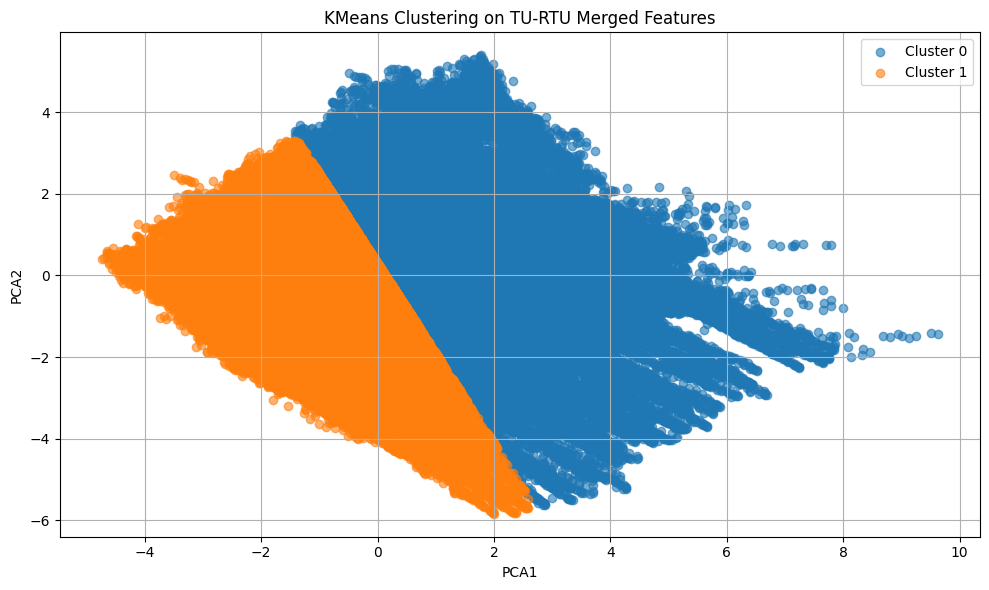

Most common cluster for each RTU.
{'RTU_1': 1, 'RTU_2': 0}


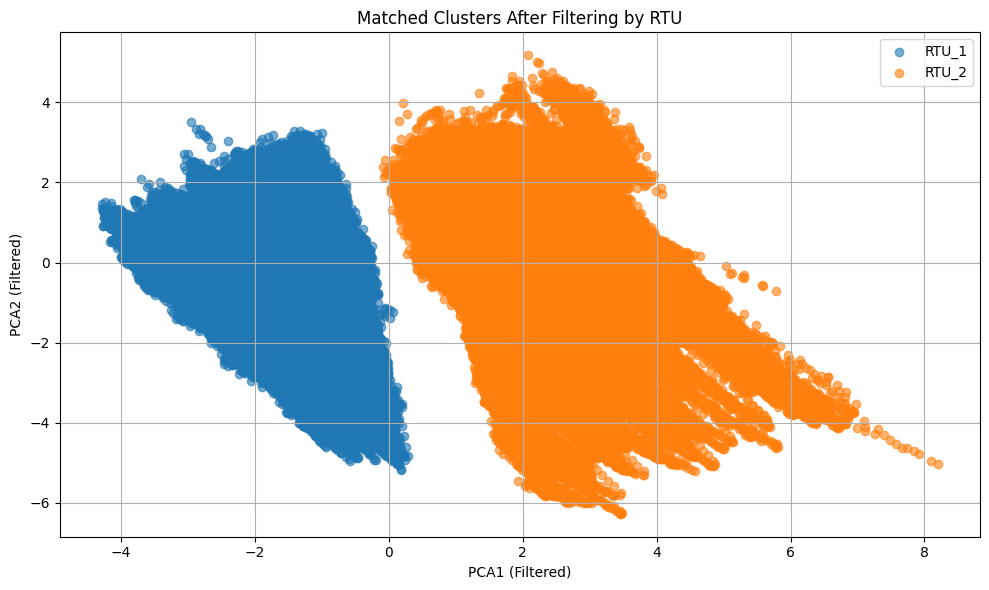

final_mapping
TU
A     RTU_1
AA    RTU_2
B     RTU_2
C     RTU_2
CC    RTU_2
DD    RTU_2
E     RTU_1
EE    RTU_2
F     RTU_1
FF    RTU_2
G     RTU_1
GG    RTU_2
H     RTU_2
HH    RTU_2
I     RTU_2
II    RTU_2
J     RTU_2
JJ    RTU_2
K     RTU_2
KK    RTU_1
L     RTU_2
LL    RTU_1
M     RTU_2
MM    RTU_1
N     RTU_2
NN    RTU_1
O     RTU_1
OO    RTU_1
P     RTU_1
PP    RTU_1
Q     RTU_2
QQ    RTU_1
R     RTU_1
RR    RTU_1
S     RTU_1
SS    RTU_1
T     RTU_2
TT    RTU_1
U     RTU_1
UU    RTU_2
V     RTU_1
W     RTU_1
X     RTU_1
Y     RTU_1
Z     RTU_1
Name: RTU, dtype: object


In [19]:
# Merge each TU with each RTU using those selected columns
merged_rows = []

for tu_name, tu_df in tu_data.items():
    for rtu_name, rtu_df in rtu_data.items():
        if all(col in tu_df.columns for col in tu_corr_cols) and all(col in rtu_df.columns for col in rtu_corr_cols):
            merged = pd.concat([
                tu_df[tu_corr_cols].add_prefix("TU_").reset_index(drop=True),
                rtu_df[rtu_corr_cols].add_prefix("RTU_").reset_index(drop=True)
            ], axis=1)
            merged["TU"] = tu_name
            merged["RTU"] = rtu_name
            merged_rows.append(merged)

# Combine all pairs together
# [TU_1 values..., RTU_1 values..., TU='TU_1', RTU='RTU_1']
# [TU_1 values..., RTU_2 values..., TU='TU_1', RTU='RTU_2']
# [TU_2 values..., RTU_1 values..., TU='TU_2', RTU='RTU_1']
# ...
full_df = pd.concat(merged_rows, ignore_index=True)

# Standardize and apply PCA
features = full_df.select_dtypes(include=np.number).drop(columns=["TU", "RTU"], errors='ignore')
scaled = StandardScaler().fit_transform(features)
pca_result = PCA(n_components=2).fit_transform(scaled)
full_df["PCA1"] = pca_result[:, 0]
full_df["PCA2"] = pca_result[:, 1]

# Clustering
kmeans = KMeans(n_clusters=len(rtu_data), random_state=42)
full_df["Cluster"] = kmeans.fit_predict(pca_result)

# Visualize initial clustering
plt.figure(figsize=(10, 6))
for c in range(len(rtu_data)):
    points = full_df[full_df["Cluster"] == c]
    plt.scatter(points["PCA1"], points["PCA2"], label=f"Cluster {c}", alpha=0.6)
plt.title("KMeans Clustering on TU-RTU Merged Features")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the most common cluster associated with each RTU
# For example: RTU_1 → cluster 0, RTU_2 → cluster 1
rtu_to_cluster = full_df.groupby("RTU")["Cluster"].agg(lambda x: x.value_counts().idxmax()).to_dict()

print("Most common cluster for each RTU.")
print(rtu_to_cluster)

# Keep only the rows where the cluster matches the expected RTU (based on mapping above)
full_df["ClusterMatch"] = full_df["Cluster"] == full_df["RTU"].map(rtu_to_cluster)
filtered_df = full_df[full_df["ClusterMatch"]].copy()

# Re-run PCA on filtered data for cleaner separation
filtered_features = filtered_df.select_dtypes(include=np.number).drop(columns=["PCA1", "PCA2", "Cluster"], errors='ignore')
filtered_scaled = StandardScaler().fit_transform(filtered_features)
filtered_pca = PCA(n_components=2).fit_transform(filtered_scaled)
filtered_df["PCA1_final"] = filtered_pca[:, 0]
filtered_df["PCA2_final"] = filtered_pca[:, 1]

# Visualize final matched clustering
plt.figure(figsize=(10, 6))
for rtu in rtu_data.keys():
    points = filtered_df[filtered_df["RTU"] == rtu]
    plt.scatter(points["PCA1_final"], points["PCA2_final"], label=rtu, alpha=0.6)
plt.title("Matched Clusters After Filtering by RTU")
plt.xlabel("PCA1 (Filtered)")
plt.ylabel("PCA2 (Filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For each TU, pick the RTU it got paired with most often
final_mapping = filtered_df.groupby("TU")["RTU"].agg(lambda x: x.value_counts().idxmax())
tu_df = pd.DataFrame(index=tu_data.keys())
tu_df["Assigned_RTU"] = tu_df.index.map(final_mapping)

print("final_mapping")
print(final_mapping)

### Correlation-Based TU to RTU Mapping (No Clustering)
*  We now assign each TU to the RTU it correlates most strongly with, based on selected top features.


In [20]:
import os
import pandas as pd
import numpy as np

# Load folders
tu_path = "./data_Bini/cleaned_data/cleaned_TUs_synced"
rtu_path = "./data_Bini/cleaned_data/cleaned_RTUs_synced"
excluded = {"BB.csv", "D.csv"}  # we don't want to use these TU files

# Load TU and RTU files (using highly correlated columns calculated previously)
tu_data = {}
for file in sorted(os.listdir(tu_path)):
    if file.endswith(".csv") and file not in excluded:
        name = file[:-4]
        df = pd.read_csv(os.path.join(tu_path, file))
        df = df.set_index('record_index').sort_index()
        df = (df[tu_corr_cols].select_dtypes(include=np.number).dropna())
        tu_data[name] = df

rtu_data = {}
for file in sorted(os.listdir(rtu_path)):
    if file.endswith(".csv") and "RTU_3" not in file:
        name = file[:-4]
        df = pd.read_csv(os.path.join(rtu_path, file))
        df = df.set_index('record_index').sort_index()
        df = (df[rtu_corr_cols].select_dtypes(include=np.number).dropna())
        rtu_data[name] = df

# Correlation-Based TU → RTU Assignment (vectorized)
tu_to_rtu_map = {}
for tu_name, df_tu in tu_data.items():
    best_rtu, best_corr = None, -np.inf

    for rtu_name, df_rtu in rtu_data.items():
        common = df_tu.columns.intersection(df_rtu.columns)
        if common.empty:
            continue
        # vectorized correlation
        avg_corr = df_tu[common].corrwith(df_rtu[common], axis=0).abs().mean()

        if avg_corr > best_corr:
            best_corr, best_rtu = avg_corr, rtu_name

    tu_to_rtu_map[tu_name] = best_rtu

print(tu_to_rtu_map)


{'A': 'RTU_2', 'AA': 'RTU_2', 'B': 'RTU_2', 'C': 'RTU_2', 'CC': 'RTU_1', 'DD': 'RTU_2', 'E': 'RTU_2', 'EE': 'RTU_2', 'F': 'RTU_2', 'FF': 'RTU_2', 'G': 'RTU_2', 'GG': 'RTU_2', 'H': 'RTU_2', 'HH': 'RTU_2', 'I': 'RTU_2', 'II': 'RTU_2', 'J': 'RTU_2', 'JJ': 'RTU_2', 'K': 'RTU_2', 'KK': 'RTU_2', 'L': 'RTU_2', 'LL': 'RTU_1', 'M': 'RTU_2', 'MM': 'RTU_1', 'N': 'RTU_2', 'NN': 'RTU_1', 'O': 'RTU_2', 'OO': 'RTU_1', 'P': 'RTU_2', 'PP': 'RTU_2', 'Q': 'RTU_1', 'QQ': 'RTU_1', 'R': 'RTU_1', 'RR': 'RTU_1', 'S': 'RTU_1', 'SS': 'RTU_1', 'T': 'RTU_1', 'TT': 'RTU_1', 'U': 'RTU_1', 'UU': 'RTU_1', 'V': 'RTU_1', 'W': 'RTU_1', 'X': 'RTU_1', 'Y': 'RTU_1', 'Z': 'RTU_1'}
